In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
import wandb

from data import WordSequenceDataset
from model import EncoderOnlyNextTokenPredictor

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  
    return text

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 100
learning_rate = 1e-3
window_size = 3
max_vocab_size = 50

In [4]:
dataset = WordSequenceDataset("data/simple_corpus.txt", window_size=window_size, max_vocab_size=max_vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[DEBUG] final samples : 1716


In [5]:
print("# of vocabs", dataset.vocab_size)
print("Top 20 vocabs:", list(dataset.token2idx.keys())[2:22])

# of vocabs 50
Top 20 vocabs: ['not', 'do', 'they', 'you', 'she', 'he', 'we', 'i', 'want', 'to', 'a', 'hate', 'love', 'need', 'drink', 'prefer', 'like', 'eat', 'tea', 'salad']


### Dataset & Dataloader

### Model setup

In [6]:
model = EncoderOnlyNextTokenPredictor(vocab_size=dataset.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Loop

In [7]:
wandb.finish()

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sykim627 (25th-project-BubbleFreeNewsletter). Use `wandb login --relogin` to force relogin


True

In [9]:
wandb.init(project="embedding-visualization", config={
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
    "max_vocab_size": max_vocab_size
})

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fa275173100, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fa275172cb0, raw_cell="wandb.init(project="embedding-visualization", conf.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X12sdnNjb2RlLXJlbW90ZQ%3D%3D> result=<wandb.sdk.wandb_run.Run object at 0x7f9f151c2f20>>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [10]:
wandb.watch(model.token_embedding, log="all", log_freq=10)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        grad_norm = torch.norm(model.token_embedding.embedding.weight.grad)
        wandb.log({"embedding_grad_norm": grad_norm.item()})

        embedding_weights = model.token_embedding.embedding.weight.detach().cpu().numpy()
        wandb.log({
            "embedding_weights_step": wandb.Histogram(embedding_weights.flatten())
        })

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    wandb.log({"loss": avg_loss, "epoch": epoch})


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9f1480ceb0, raw_cell="wandb.watch(model.token_embedding, log="all", log_.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X13sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Epoch 1: Loss = 2.8652
Epoch 2: Loss = 1.8764
Epoch 3: Loss = 1.5978
Epoch 4: Loss = 1.5327
Epoch 5: Loss = 1.5101
Epoch 6: Loss = 1.5065
Epoch 7: Loss = 1.4945
Epoch 8: Loss = 1.4905
Epoch 9: Loss = 1.4914
Epoch 10: Loss = 1.4845
Epoch 11: Loss = 1.4817
Epoch 12: Loss = 1.4788
Epoch 13: Loss = 1.4838
Epoch 14: Loss = 1.4781
Epoch 15: Loss = 1.4779
Epoch 16: Loss = 1.4739
Epoch 17: Loss = 1.4714
Epoch 18: Loss = 1.4776
Epoch 19: Loss = 1.4735
Epoch 20: Loss = 1.4715
Epoch 21: Loss = 1.4714
Epoch 22: Loss = 1.4686
Epoch 23: Loss = 1.4711
Epoch 24: Loss = 1.4654
Epoch 25: Loss = 1.4683
Epoch 26: Loss = 1.4670
Epoch 27: Loss = 1.4668
Epoch 28: Loss = 1.4677
Epoch 29: Loss = 1.4685
Epoch 30: Loss = 1.4681
Epoch 31: Loss = 1.4629
Epoch 32: Loss = 1.4597
Epoch 33: Loss = 1.4635
Epoch 34: Loss = 1.4622
Epoch 35: Loss = 1.4667
Epoch 36: Loss = 1.4599
Epoch 37: Loss = 1.4660
Epoch 38: Loss = 1.4679
Epoch 39: Loss = 1.4627
Epoch 40: Loss = 1.4608
Epoch 41: Loss = 1.4693
Epoch 42: Loss = 1.4591
E

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

### Non-contextual visualization

In [11]:
def visualize_token_embeddings(model, idx2token):
    emb = model.token_embedding.embedding.weight.detach().cpu().numpy()
    reduced = TSNE(n_components=2, perplexity=5).fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for i, label in idx2token.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    plt.title("Non-Contextual Token Embedding")
    plt.grid(True)
    plt.show()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9ebce37f70, raw_cell="def visualize_token_embeddings(model, idx2token):
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X15sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f9ebce37f40, execution_count=11 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f9ebce37f70, raw_cell="def visualize_token_embeddings(model, idx2token):
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X15sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9f151c3fd0, raw_cell="visualize_token_embeddings(model, dataset.idx2toke.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X16sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

/root/25-1_DS_Week03/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/25-1_DS_Week03/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


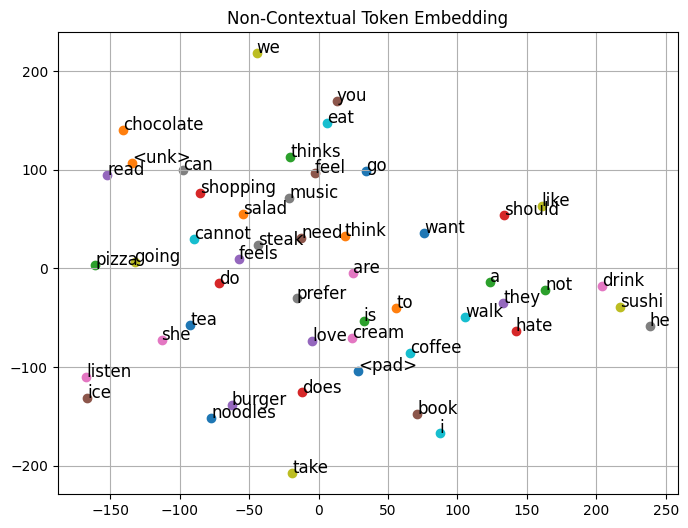

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f9f151c2a40, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f9f151c3fd0, raw_cell="visualize_token_embeddings(model, dataset.idx2toke.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X16sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [12]:
visualize_token_embeddings(model, dataset.idx2token)

### Contextual Embedding

In [13]:
def extract_contextual_embeddings(model, sentence, token2idx):
    model.eval()
    tokens = sentence.split()
    idxs = [token2idx.get(tok, 1) for tok in tokens]  # 1 is <unk>
    x = torch.tensor([idxs]).to(device)

    with torch.no_grad():
        tok_emb = model.token_embedding(x)
        pos_emb = model.pos_embedding(x)
        x = tok_emb + pos_emb
        for layer in model.encoder_layers:
            x = layer(x)
        x = model.norm(x)
        return x.squeeze(0).cpu().numpy(), tokens

def visualize_contextual_embeddings(model, token2idx, sentences):
    vectors = []
    labels = []
    for sentence in sentences:
        vecs, toks = extract_contextual_embeddings(model, sentence, token2idx)
        vectors.extend(vecs)
        labels.extend([f"{tok} ({sentence})" for tok in toks])

    reduced = TSNE(n_components=2, perplexity=3).fit_transform(np.array(vectors))

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=10)
    plt.title("Contextual Embeddings by Sentence")
    plt.grid(True)
    plt.show()


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9f151c3e50, raw_cell="def extract_contextual_embeddings(model, sentence,.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fa040e324d0, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f9f151c3e50, raw_cell="def extract_contextual_embeddings(model, sentence,.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fa040ce6d40, raw_cell="sentences = ["He plays game", "He is tired"]
visua.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X22sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

/root/25-1_DS_Week03/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/25-1_DS_Week03/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


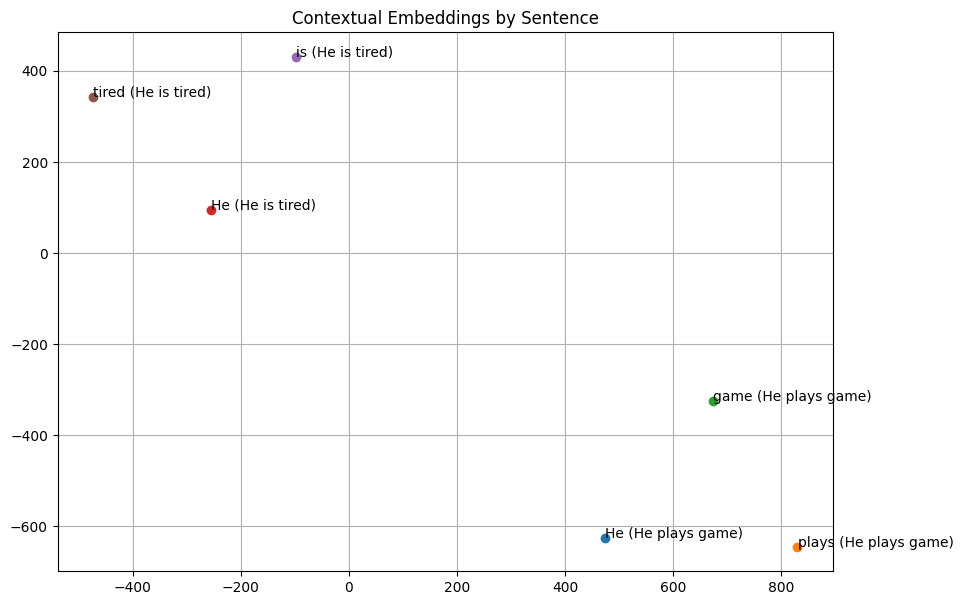

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9f1514e4a0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fa040ce7070, execution_count=17 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fa040ce6d40, raw_cell="sentences = ["He plays game", "He is tired"]
visua.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bassignment-1742879880/root/25-1_DS_week03/25-1_DS_Week03/Assignment02/train.ipynb#X22sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [17]:
sentences = ["He plays game", "He is tired"]
visualize_contextual_embeddings(model, dataset.token2idx, sentences)